In [1]:
import pickle

import numpy as np
import pandas as pd
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import GPy

In [2]:
grid = pd.read_csv('combined.csv')
grid['DATE'] = pd.to_datetime(grid['SETTLEMENT_DATE'], format='%d-%b-%Y')

In [3]:
grid_average = grid.groupby('DATE').agg(DEMAND_AVERAGE=pd.NamedAgg('ND',aggfunc=np.mean)).reset_index()
grid_average['YEAR'] = grid_average['DATE'].dt.year
grid_average['DOY'] = grid_average['DATE'].dt.dayofyear

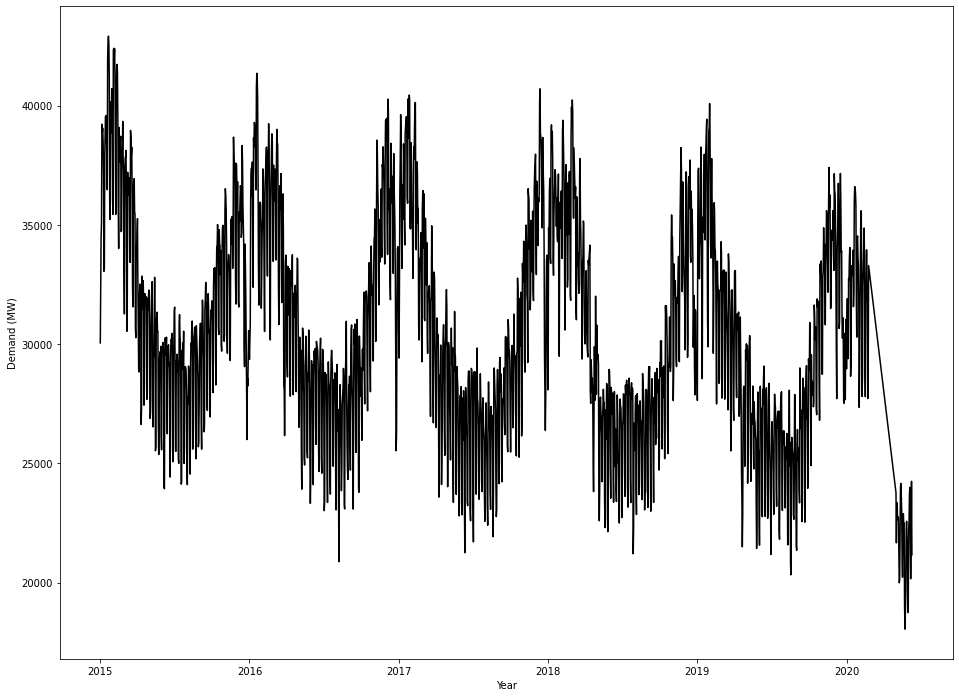

In [4]:
plt.figure(figsize=(16,12))
plt.plot(grid_average.DATE, grid_average.DEMAND_AVERAGE, c='k')
plt.xlabel('Year'), plt.ylabel('Demand (MW)')
plt.show()

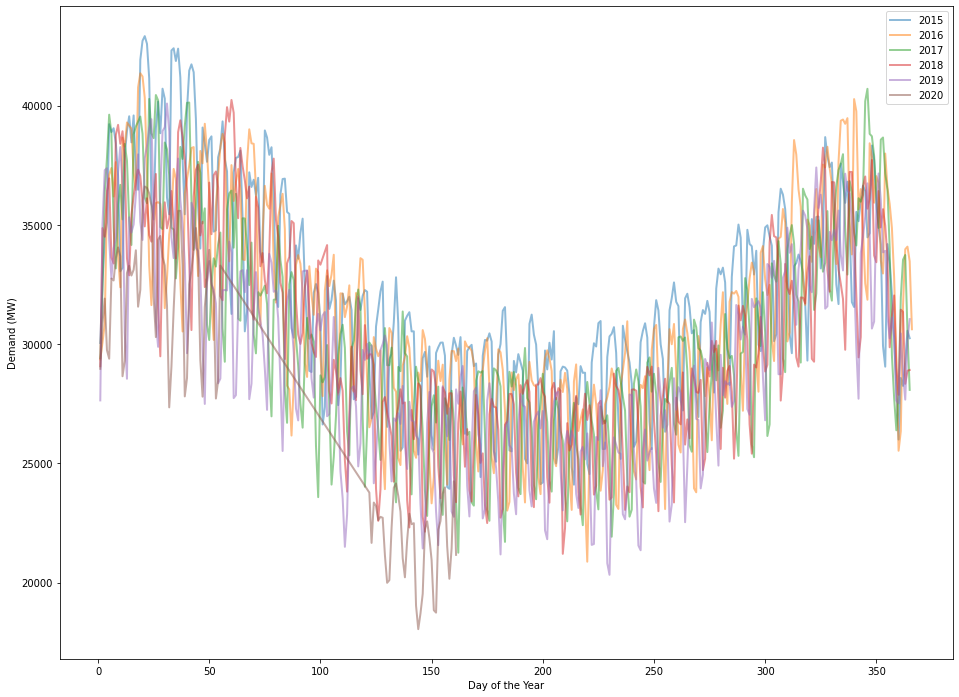

In [5]:
plt.figure(figsize=(16,12))
for year in np.unique(grid_average.YEAR.values):
    plt.plot(grid_average.DOY[grid_average.YEAR.values==year], grid_average.DEMAND_AVERAGE[grid_average.YEAR.values==year], linewidth=2, alpha=0.5, label=str(year))
plt.xlabel('Day of the Year'), plt.ylabel('Demand (MW)')
plt.legend()
plt.show()

In [6]:
# Get the number of (decimal) years passed since the beginning of the data series (X)
# and the average daily demand in GW.
OFFSET = 0
X = []
for year in np.unique(grid_average.YEAR.values):
    DOY = OFFSET + grid_average.DOY[grid_average.YEAR.values==year]
    X += [i for i in DOY]
    OFFSET += max(grid_average.DOY[grid_average.YEAR.values==year])

X = np.expand_dims(np.array(X)/365, axis=1)
Y = np.expand_dims(grid_average.DEMAND_AVERAGE.values/1000, axis=1)


Name : GP regression
Objective : 9771.482862900924
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  GP_regression.                            |                 value  |  constraints  |  priors
  sum.bias.variance                         |                   1.0  |      +ve      |        
  sum.rbf.variance                          |                   1.0  |      +ve      |        
  sum.rbf.lengthscale                       |                  50.0  |      +ve      |        
  sum.mul.rbf.variance                      |                   1.0  |      +ve      |        
  sum.mul.rbf.lengthscale                   |                 100.0  |      +ve      |        
  sum.mul.periodic_exponential.variance     |                   1.0  |      +ve      |        
  sum.mul.periodic_exponential.lengthscale  |  0.019230769230769232  |      +ve      |        
  sum.mul.periodic_exponential.period       |                   1.0  |      +ve      |        
  G

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f6adb6ccac8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f6ad91bbc88>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f6adb6ccdd8>]}

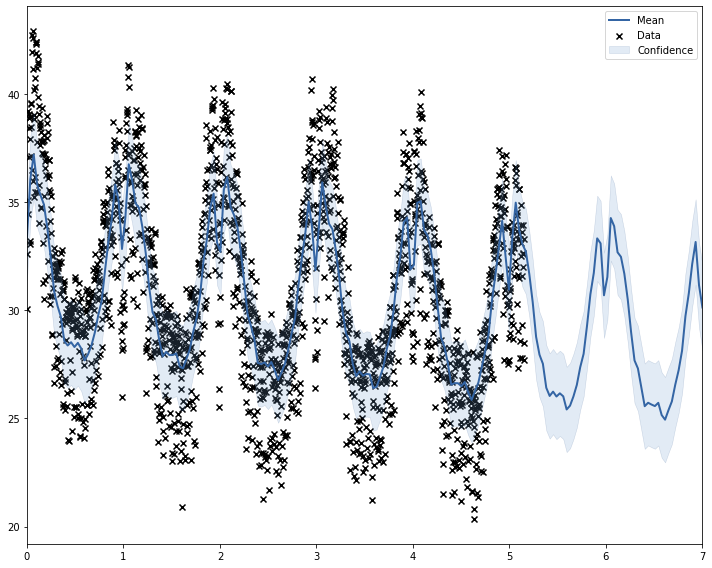

In [7]:
# Set up the model.
COVID_CUTOFF = 1881
#kernel = GPy.kern.Bias(input_dim=1, variance=1) + GPy.kern.Linear(input_dim=1) \
#        + GPy.kern.RBF(input_dim=1, lengthscale=100)*GPy.kern.PeriodicExponential(input_dim=1, lengthscale=1/52, period=1)

# Kernel: Bias to account for offset, RBF with long length scale to account for decreasing trend,
# and RBF *times* PeriodicExponential to account for seasonal variations, with decreasing influence.
kernel = GPy.kern.Bias(input_dim=1, variance=1) + GPy.kern.RBF(input_dim=1, lengthscale=50) \
        + GPy.kern.RBF(input_dim=1, lengthscale=100)*GPy.kern.PeriodicExponential(input_dim=1, lengthscale=1/52, period=1) \

# Set up the model.
m = GPy.models.GPRegression(X[:COVID_CUTOFF], Y[:COVID_CUTOFF], kernel)
print(m)
m.plot(figsize=(10,8), plot_limits=[0,7])


Name : GP regression
Objective : 4389.5584019540265
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  GP_regression.                            |               value  |  constraints  |  priors
  sum.bias.variance                         |  233.54091354996189  |      +ve      |        
  sum.rbf.variance                          |   418.7301358486422  |      +ve      |        
  sum.rbf.lengthscale                       |   28.76239770400877  |      +ve      |        
  sum.mul.rbf.variance                      |  267.09504812367436  |      +ve      |        
  sum.mul.rbf.lengthscale                   |   99.88694683349343  |      +ve      |        
  sum.mul.periodic_exponential.variance     |   267.0950481236756  |      +ve      |        
  sum.mul.periodic_exponential.lengthscale  |  126.10020071452414  |      +ve      |        
  sum.mul.periodic_exponential.period       |  1.0018474798367207  |      +ve      |        
  Gaussian_noise.var

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f6b035975c0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f6b03597588>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f6b03597b00>]}

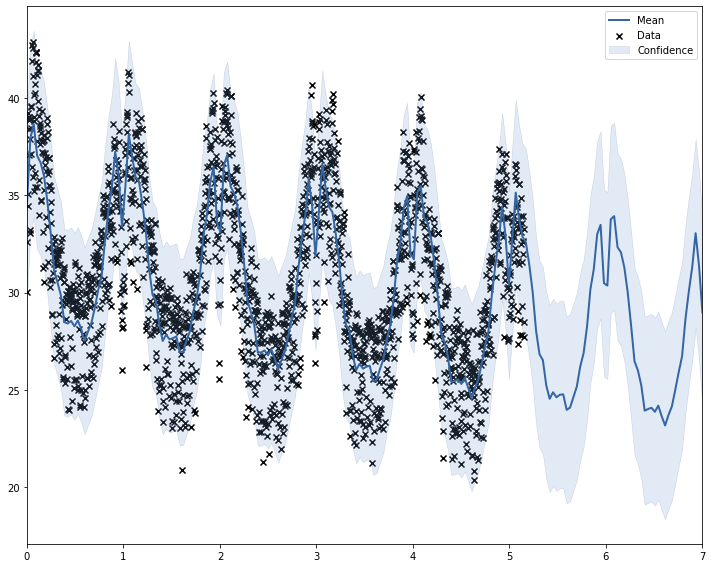

In [8]:
# OPtimise the model.
m.optimize()
print(m)
m.plot(figsize=(10,8), plot_limits=[0,7])

In [9]:
X_PREDICT = np.expand_dims(np.linspace(0,7,1000), axis=1)
Y_PREDICT_mean, Y_PREDICT_conf = m.predict(X_PREDICT)

X_COVID = X[COVID_CUTOFF:]
Y_COVID = Y[COVID_CUTOFF:]
Y_COVID_PREDICT_mean, Y_COVID_PREDICT_conf = m.predict(X_COVID)

In [11]:
model_output = {'X_PREDICT': X_PREDICT,
                'Y_PREDICT_mean': Y_PREDICT_mean,
                'Y_PREDICT_conf': Y_PREDICT_conf,
                'X_COVID': X_COVID,
                'Y_COVID': Y_COVID,
                'Y_COVID_PREDICT_mean': Y_COVID_PREDICT_mean,
                'Y_COVID_PREDICT_conf': Y_COVID_PREDICT_conf}
with open('model_output.p', 'wb') as f:
    pickle.dump(model_output, f)

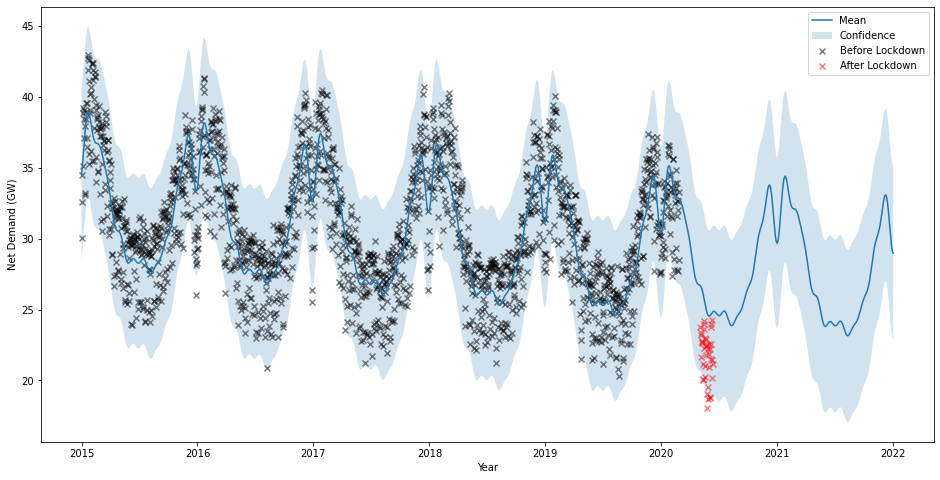

In [12]:
plt.figure(figsize=(16,8))
plt.fill_between(X_PREDICT.flatten(), (Y_PREDICT_mean-Y_PREDICT_conf).flatten(), (Y_PREDICT_mean+Y_PREDICT_conf).flatten(), alpha=0.2, label='Confidence')
plt.plot(X_PREDICT, Y_PREDICT_mean, label='Mean')
plt.scatter(X[:COVID_CUTOFF],Y[:COVID_CUTOFF], c='k', marker='x', alpha=0.5, label='Before Lockdown')
plt.scatter(X[COVID_CUTOFF:],Y[COVID_CUTOFF:], c='red', marker='x', alpha=0.5, label='After Lockdown')
plt.xlabel('Year'); plt.ylabel('Net Demand (GW)')
plt.xticks(np.arange(8), np.arange(8)+2015)
plt.legend()

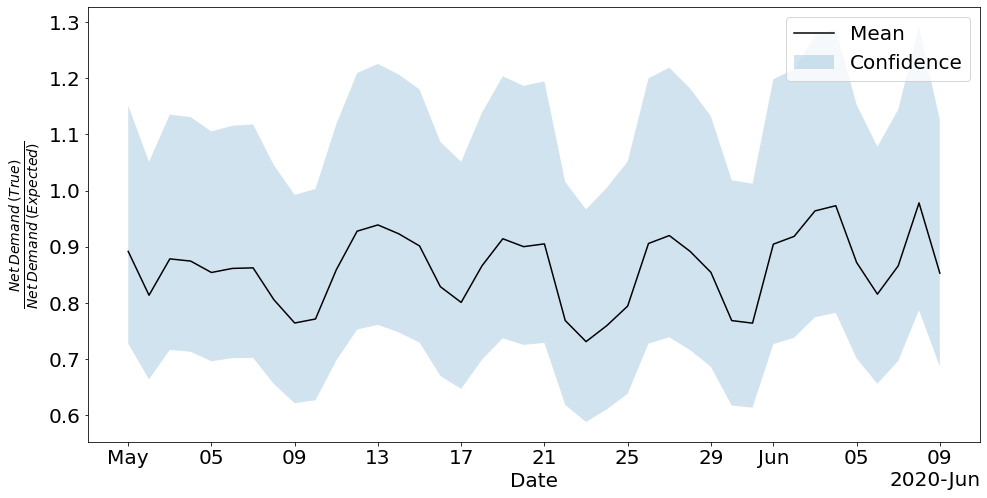

In [13]:
conf_min = Y_COVID.flatten()/(Y_COVID_PREDICT_mean.flatten()+Y_COVID_PREDICT_conf.flatten())
conf_max = Y_COVID.flatten()/(Y_COVID_PREDICT_mean.flatten()-Y_COVID_PREDICT_conf.flatten())

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(16,8))

locator = mdates.AutoDateLocator(minticks=6, maxticks=12)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.fill_between(grid_average.DATE[COVID_CUTOFF:], conf_min, conf_max, alpha=0.2, label='Confidence')
ax.plot(grid_average.DATE[COVID_CUTOFF:], Y_COVID.flatten()/Y_COVID_PREDICT_mean.flatten(), c='k', label='Mean')
ax.set_xlabel('Date'); ax.set_ylabel('$\\frac{Net \\: Demand \\: (True)}{Net \\: Demand \\: (Expected)}$')
plt.legend()
plt.show()

In [1]:
# Example of using the wrapper.
from griddata import GridData
grid_data = GridData('combined.csv')

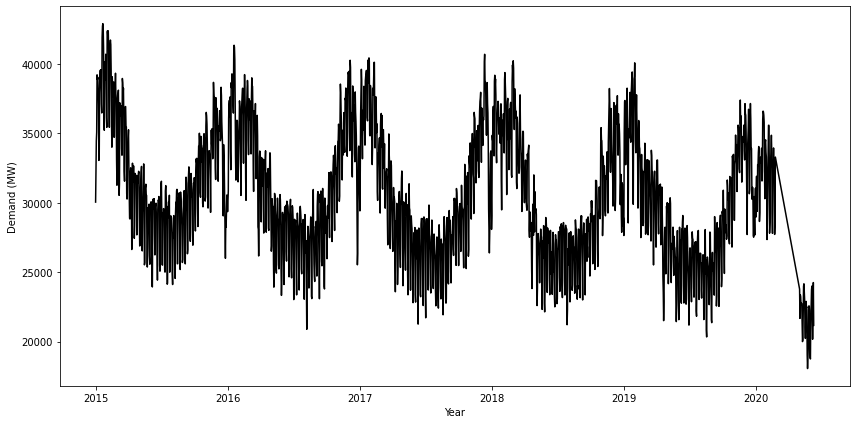

In [2]:
grid_data.plot_demand(collapse=False, figsize=(12,6), color='k')

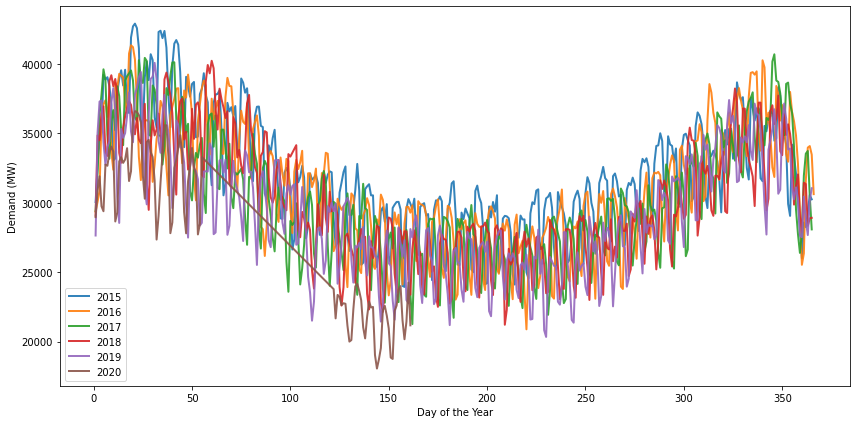

In [3]:
grid_data.plot_demand(collapse=True, figsize=(12,6), color='k')

In [4]:
grid_data.load_model_output('model_output.p')

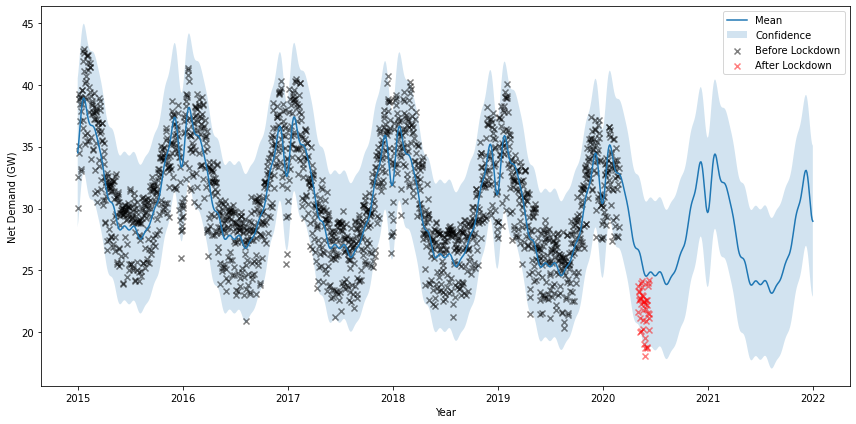

In [5]:
grid_data.plot_model(figsize=(12,6))

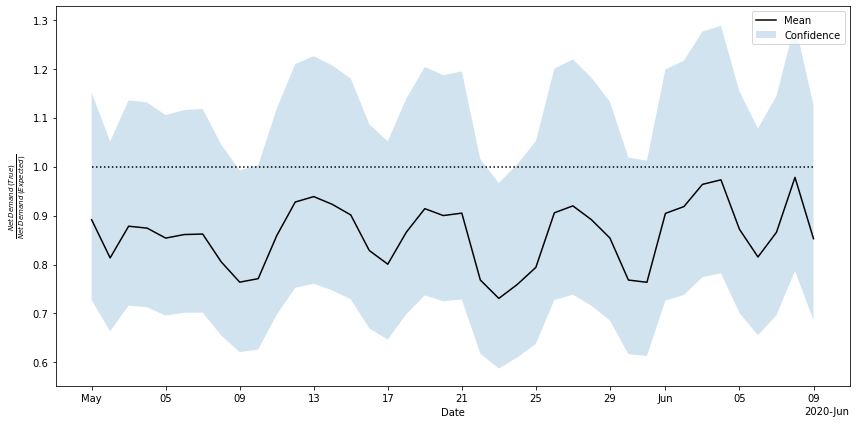

In [8]:
grid_data.plot_demand_discrepancy(figsize=(12,6), plot_confidence=True)